# Exploratory data analysis

This notebook explores the features extracted from TREMBL protein dataset from Uniprot.

Here is a general description of this dataset [(source)](https://img.jgi.doe.gov/datasource.html):

_UniProt/TrEMBL (Translated EMBL Nucleotide Sequence Data Library) is a computer-annotated protein sequence database complementing the UniProt/SwissProt protein knowledgebase. Recognizing that sequence data were being generated at a pace exceeding SwissProt's ability to keep up, TrEMBL was created to provide automated annotations for those proteins not in SwissProt. UniProt/TrEMBL contains the translations of all coding sequences (CDS) present in the EMBL/GenBank/DDBJ nucleotide sequence databases and also protein sequences extracted from the literature or submitted to UniProt/Swiss-Prot. The database is enriched with automated classification and annotation. All protein translations submitted to the GenBank/EMBL/DDBJ nucleotide sequence databases are automatically incorporated into the next incremental UniProt Knowledgebase release (fortnightly)._

Features of interest were extracted from the XML dataset into a tabular format and their distributions and relationships are analyzed here

In [1]:
import itertools as it
from typing import Iterable, Dict
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

The entire Trembl set is way too large to be analyzed in memory, so we'll take the first 3M genes to have a good idea of the features distributions:

In [2]:
%%bash
gzip -dc ../data/uniprot_trembl.tsv.gz | wc -l

Process is interrupted.


In [3]:
# Load all metadata associated with genes a sample of genes
df = pd.read_csv(
    '../data/uniprot_trembl.tsv.gz',
    sep='\t',
    usecols=range(8),
    names=['accession', 'evidence', 'citations', 'taxid', 'name', 'IPR', 'PFAM', 'GO'],
    dtype={'IPR': str, 'PFAM': str, 'GO': str, 'taxid': int},
    nrows=3000000
)


In [4]:
def fmt_terms(vec: pd.Series) -> pd.Series:
    vec = vec.str.split('|')
    vec = vec.apply(lambda d: d if isinstance(d, list) else [])
    return vec

def get_all_terms_counts(vec: pd.Series) -> Dict[str, int]:
    """Given a series of lists of terms, return the set of terms
    with their number of occurences"""
    all_terms = defaultdict(int)
    for l in vec:
        for v in l:
            all_terms[v] += 1
    return dict(all_terms)

df[['IPR', 'PFAM', 'GO']] = df[['IPR', 'PFAM', 'GO']].apply(
    fmt_terms, axis=0
)

In [5]:
df[['IPR', 'PFAM', 'GO']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   IPR     object
 1   PFAM    object
 2   GO      object
dtypes: object(3)
memory usage: 68.7+ MB


In [6]:
df

,accession,evidence,citations,taxid,name,IPR,PFAM,GO
0,A0A375IQD5,predicted,1,164546,"Putative transcriptional regulator, HTH arsR f...","[IPR011991, IPR001845, IPR036388, IPR036390]",[],[GO:0003700]
1,A0A397C8L6,predicted,1,112090,Uncharacterized protein,[],[],[GO:0016021]
2,A0A397CNE3,predicted,1,112090,Uncharacterized protein,[],[],[]
3,A0A397EUB1,predicted,2,112090,Uncharacterized protein,[],[],[]
4,A0A412FCB4,predicted,2,47678,Peptidase C11,[IPR005077],[PF03415],[]
...,...,...,...,...,...,...,...,...
2999995,A0A2M7FS64,inferred from homology,1,1973953,Multidrug transporter,"[IPR003423, IPR010131]",[PF02321],"[GO:0016021, GO:0005886, GO:0015562]"
2999996,A0A2M7FTR1,predicted,1,1973953,DNA polymerase III subunit delta,[IPR027417],[],[]
2999997,A0A2M7FW47,predicted,1,1973953,Glutamate dehydrogenase,"[IPR036291, IPR028971, IPR007780]",[PF05088],"[GO:0004352, GO:0019551]"
2999998,A0A2M7V008,predicted,1,1974679,Uncharacterized protein,[],[],[]


The distribution of the number of terms per gene (aggregating all sources) represents the amount of information we have on that gene.
By splitting genes by type of evidence, we can see that most predicted genes have little information available.

Text(0, 0.5, 'Genes')

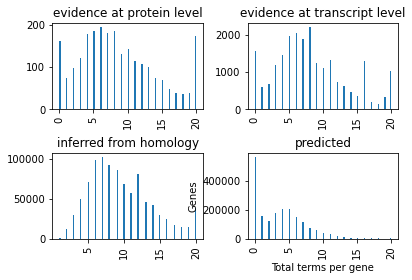

In [9]:
%matplotlib inline
n_terms_df = df[['IPR', 'PFAM', 'GO']].applymap(len)
n_terms_df.sum(axis=1).clip(upper=20).hist(bins=100, by=df.evidence)
plt.xlabel("Total terms per gene")
plt.ylabel("Genes")

Quite a lot of genes have no associated terms

In [10]:
for feat in ['GO', 'PFAM', 'IPR']:
    n = (n_terms_df[feat] == 0).sum()
    print(f"There are {n} {100 * n/df.shape[0]:.2f}% genes with 0 {feat} terms")
    
n = (n_terms_df.sum(axis=1) == 0).sum()
print(f"{n} ({100*n/df.shape[0]:.2f}%)genes have no terms at all.")

There are 1042274 34.74% genes with 0 GO terms
There are 856748 28.56% genes with 0 PFAM terms
There are 672420 22.41% genes with 0 IPR terms
566631 (18.89%)genes have no terms at all.


In [11]:
evid_mask = df.evidence.str.contains('evidence at')
for feat in ['GO', 'PFAM', 'IPR']:
    n = ((n_terms_df[feat] == 0) & evid_mask).sum()
    print(f"There are {n} {100 * n/evid_mask.sum():.2f}% strong evidence genes with 0 {feat} terms")

There are 4229 16.89% strong evidence genes with 0 GO terms
There are 3815 15.24% strong evidence genes with 0 PFAM terms
There are 2222 8.87% strong evidence genes with 0 IPR terms


Protein and transcript evidence genes should be reliable and therefore more fit to use as a training set for predictive modeling. Unfortunately, there are much fewer of these.

<AxesSubplot:ylabel='evidence'>

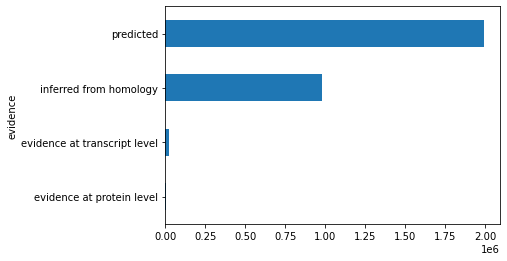

In [13]:
%matplotlib inline
df.groupby('evidence').count()['name'].plot(kind='barh')

Citations are weakly correlated with the number of terms.

Text(0.5, 0.98, '(0.045055798174250414, 9.847227706262234e-13)')

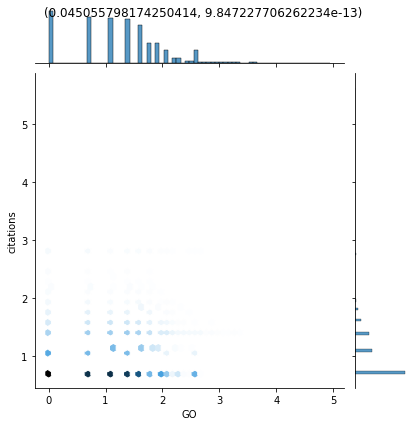

In [14]:
%matplotlib inline
import scipy.stats as ss
sns.jointplot(x=np.log1p(n_terms_df['GO'][evid_mask]), y=np.log1p(df.citations[evid_mask]), kind='hex')
plt.suptitle(ss.pearsonr(n_terms_df['GO'][evid_mask], df.citations[evid_mask]))

Looking at the overall distribution of terms reveals that a few terms are extremely frequent, while most terms are seen only a few times. This seems especially true for IPR terms.

In [15]:
all_terms = {cat: get_all_terms_counts(df[cat]) for cat in ['IPR', 'PFAM', 'GO']}

Text(0.5, 0.98, 'Abundance of terms')

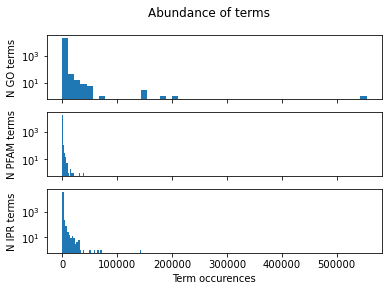

In [17]:
%matplotlib inline
fig, ax = plt.subplots(3, 1, sharex=True)
for i, feat in enumerate(['GO', 'PFAM', 'IPR']):
    ax[i].hist(all_terms[feat].values(), bins=50)
    ax[i].set_ylabel(f"N {feat} terms")
    ax[i].set_yscale('log')
    

plt.xlabel("Term occurences")
plt.suptitle("Abundance of terms")

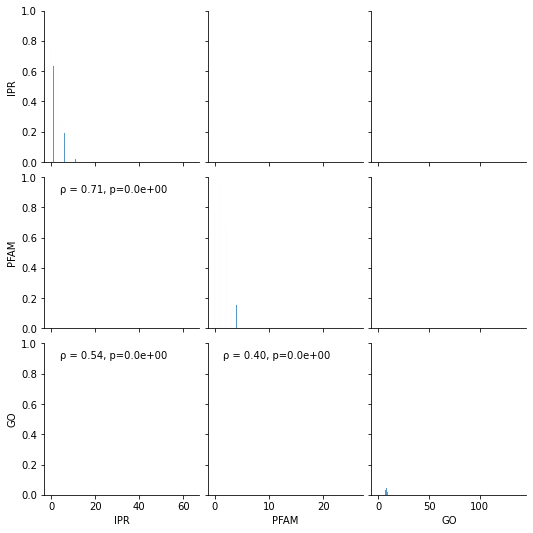

In [18]:
%matplotlib inline
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}, p={p:.1e}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(n_terms_df, kind='hex')
g.map_lower(corrfunc)

In [19]:
# Matrix of co-occurence
def terms_co_occ(vec: pd.Series) -> np.ndarray:
    """Given a series of list of terms, return their
    matrix of co-occurences (in genes).
    """
    terms = list(get_all_terms_counts(vec).keys())
    term_ids = np.argsort(terms)
    mapping = {k: v for k, v in zip(terms, term_ids)}
    mat = csr_matrix((len(terms), len(terms)), dtype=int)
    for gene in vec:
        for t1, t2 in it.combinations(gene, 2):
            mat[mapping[t1], mapping[t2]] += 1
    return mat


mat = terms_co_occ(df.IPR[evid_mask])
# Clustering

/home/varogh/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


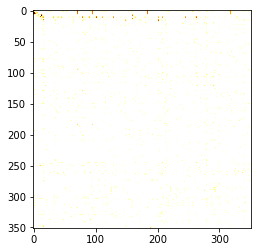

In [20]:
%matplotlib inline
import scipy.cluster.hierarchy as sch



def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx], idx

filt_high = (mat.sum(axis=0) > 80).A1
co_mat = cluster_corr(mat[filt_high, :][:, filt_high].toarray())[0]
plt.imshow(np.log1p(co_mat), cmap='afmhot_r')

Text(0.5, 0.98, 'Network of terms co-occurence')

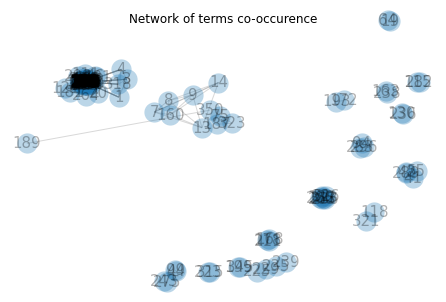

In [21]:
%matplotlib inline
import networkx as nx
#from sklearn.cluster import AgglomerativeClustering


#   clusters = AgglomerativeClustering(3).fit_predict(m)
nx.draw_kamada_kawai(
    nx.Graph(co_mat),
    with_labels=True,
    node_size=400,
    edge_color='grey',
    linewidths=.1,
    font_size=15,
    alpha=0.3,
)

plt.suptitle("Network of terms co-occurence")

## Analysis of strong evidence dataset

We filtered the entire Trembl dataset to keep all transcript- and protein-level evidence genes. These will be used as the training set. We also formatted tables in the long format for convenience.

In [22]:
import pandas as pd
import numpy as np
seqs = pd.read_csv('../data/train/sequences.tsv.gz', sep='\t')['seq']

Text(0, 0.5, 'Genes')

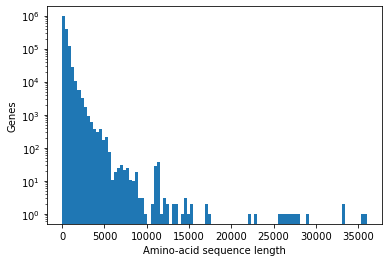

In [23]:
seqs.apply(len).plot(kind='hist', bins=100, logy=True)
plt.xlabel('Amino-acid sequence length')
plt.ylabel("Genes")

In [24]:
print(
    f"{100*(seqs.apply(len) < 1000).sum() / len(seqs):.2f}% sequences are shorter than 1000 aa."
) 

95.73% sequences are shorter than 1000 aa.


In [25]:
names = pd.read_csv('../data/train/names.tsv.gz', sep='\t')

2 genes have no valid names, but they both have other names. Some of those names are arbitrary IDs, we may have to filter that out.

In [26]:
names.loc[names['name'].isnull()]


,id,name
847619,Q9FKN5,NaN
1990028,Q9FL00,NaN


In [27]:
no_name_ids = names.id[names.name.isnull()]
names.loc[names.id.isin(no_name_ids), :]

,id,name
847616,Q9FKN5,Cardiomyopathy-associated protein
847617,Q9FKN5,Gb
847618,Q9FKN5,AAC35233.1
847619,Q9FKN5,NaN
1990026,Q9FL00,Emb
1990027,Q9FL00,CAB62433.1
1990028,Q9FL00,NaN
1990029,Q9FL00,Membrane-associated kinase regulator-like protein


In [28]:
n_names_per_gene = names.groupby('id').apply(len)

Most genes have <10 names, but some have up to 40

Text(0, 0.5, 'Genes')

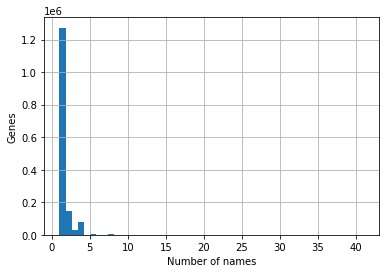

In [29]:
n_names_per_gene.hist(bins=50)
plt.xlabel("Number of names")
plt.ylabel("Genes")

Genes that have high numbers of names have very similar names.

In [30]:
many_names_genes = n_names_per_gene[n_names_per_gene == max(n_names_per_gene)]
names.loc[names.id.isin(many_names_genes.index.values), :]

,id,name
175513,A5HUP3,Alpha-atrial natriuretic peptide
175514,A5HUP3,Alpha-hANP
175515,A5HUP3,Atrial natriuretic factor
175516,A5HUP3,Atrial natriuretic factor 1-33
175517,A5HUP3,Atrial natriuretic factor 3-33
...,...,...
2016727,Q9TQW1,Pro atrial natriuretic peptide 79-98
2016728,Q9TQW1,Pro atrial natriuretic peptide 95-126
2016729,Q9TQW1,Urodilatin
2016730,Q9TQW1,Vessel dilator


In [31]:
seqs.shape

(1537809,)

In [32]:
n_names_per_gene.shape

(1537809,)

In [33]:
longest = names.head(5000).groupby('id')['name'].apply(lambda g: g[g.str.len() == g.str.len().max()])

Text(0, 0.5, 'Genes')

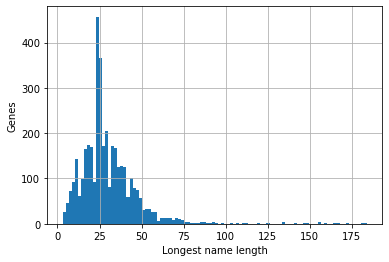

In [34]:
%matplotlib inline
longest.apply(len).hist(bins=100)
plt.xlabel("Longest name length")
plt.ylabel("Genes")

In [35]:
longest.tail()

id          
X2G6D2  2688    Mitogen-activated protein kinase
X2KPD8  1170                Elongation factor 1a
X4YJX3  4996                       C-type lectin
X5DB11  4180                            CYP4M-84
X5J5R3  3320         IgG1 heavy chain VDJ region
Name: name, dtype: object

Inspecting the most frequent names reveal a few uninformative descriptors, such as "3'ORF", "Uncharacterized protein" or "Predicted protein".
There are also very vague terms, like "Negative factor" or "Putative secreted protein"

In [43]:
unq_names, cnt_names = np.unique(names.loc[~names['name'].isnull(), 'name'], return_counts=True)

In [48]:
unq_names[np.argsort(cnt_names)][-50:]

array(['N-acetylmuramic acid 6-phosphate lyase',
       'N-acetylmuramic acid 6-phosphate hydrolase',
       'N-acetylmuramic acid 6-phosphate etherase',
       'Dinitrogenase reductase', 'Protein Wnt',
       'Putative conserved plasma membrane protein',
       'Glycosyltransferase', 'Nucleoprotein', 'Coat protein', 'P1D',
       'P1C', 'Virion protein 3', 'Virion protein 1',
       'Capsid protein VP3', 'Capsid protein VP1',
       'Carboxylic ester hydrolase', 'Major surface glycoprotein G',
       'Attachment glycoprotein G', 'RNA-directed RNA polymerase',
       'Erythrocyte membrane protein 1', 'Nucleocapsid protein',
       'Cytochrome P450', 'MHC class II antigen',
       'Non-specific serine/threonine protein kinase', 'RNA helicase',
       'Glycoprotein 120', 'Putative LOV domain-containing protein',
       'Conotoxin', 'Odorant receptor', 'Genome polyprotein',
       'Retropepsin', 'Protease', 'Putative secreted protein',
       'MHC class I antigen', 'p7', 'SOR protein', 'p